## Dataset results summary

**Purpose**: Compare and analyze scores that multiple LLM evaluators assign to stories against the baseline (Claude Sonnet 4).
**Flow**: 1) Raw score overview → 2) Bias vs baseline → 3) MAE/RMSE error metrics


### Summary: Setup
- Libraries: `numpy`, `pandas`, `matplotlib`, `seaborn`
- Theme: `whitegrid`, DPI 120

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from collections import Counter

sns.set_theme(style="whitegrid", font_scale=0.95)
plt.rcParams["figure.dpi"] = 120


### Data loading
- Load each evaluator result from `dataset/results/*_result.csv`
- `Claude-Sonnet-4(LLMasJudge).csv` = baseline reference

In [9]:
# Discover and load all evaluator result files
results_dir = Path("../dataset/results")
result_files = sorted(results_dir.glob("*_result.csv"))

# Baseline (reference) file
baseline_path = results_dir / "Claude-Sonnet-4(LLMasJudge).csv"

def pretty_name(filename_stem: str) -> str:
    s = filename_stem
    s = s.replace("_", " ")
    s = s.replace("-Instruct", "")
    s = s.replace("-it", "")
    s = s.replace("-result", "")
    s = s.replace("-2507", "")
    return s

dfs = []
for p in result_files:
    df = pd.read_csv(p)
    stem = p.name.replace("_result.csv", "")
    df["evaluator_model"] = stem
    df["evaluator_short"] = pretty_name(stem)
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)

category_cols = [c for c in all_df.columns if c.endswith("_score") and not c.startswith("creativity_")]
creativity_cols = [c for c in ["creativity_standalone_score", "creativity_contextual_score", "creativity_difference"] if c in all_df.columns]

evaluator_order = (
    all_df[["evaluator_model", "evaluator_short"]]
    .drop_duplicates()
    .sort_values("evaluator_short")
)

all_df.head()


,index,model,Adherence to Instructions_score,Believable Character Actions_score,Nuanced Characters_score,Consistent Voice / Tone of Writing_score,Imagery and Descriptive Quality_score,Elegant Prose_score,Emotionally Engaging_score,Emotionally Complex_score,...,Purple Prose_score,Overwrought_score,Incongruent Ending Positivity_score,Unearned Transformations_score,creativity_standalone_score,creativity_contextual_score,creativity_difference,influential_categories,evaluator_model,evaluator_short
0,0,deepseek-ai/DeepSeek-R1-0528,18.5,16.8,17.2,19.0,18.9,18.5,17.5,17.8,...,2.5,4.0,3.0,2.8,18.5,16.8,1.7,"Tell-Don't-Show, Weak Dialogue, Unsurprising o...",Llama-3.1-8B-Instruct,Llama-3.1-8B
1,1,deepseek-ai/DeepSeek-R1-0528,19.0,18.5,20.0,19.5,19.0,18.0,19.5,20.0,...,3.0,2.0,0.0,0.0,17.5,17.8,0.3,"Emotionally Complex, Emotionally Engaging, Ove...",Llama-3.1-8B-Instruct,Llama-3.1-8B
2,2,deepseek-ai/DeepSeek-R1-0528,19.0,18.0,17.5,19.5,18.5,17.0,19.0,18.0,...,1.0,2.0,4.0,1.0,18.5,16.0,2.5,"Unsurprising or Uncreative, Elegant Prose, Emo...",Llama-3.1-8B-Instruct,Llama-3.1-8B
3,3,deepseek-ai/DeepSeek-R1-0528,18.5,19.0,16.5,17.8,18.2,15.5,19.5,18.0,...,2.0,2.5,0.0,0.5,18.5,14.8,3.7,"Tell-Don't-Show, Weak Dialogue, Unsurprising o...",Llama-3.1-8B-Instruct,Llama-3.1-8B
4,4,deepseek-ai/DeepSeek-R1-0528,19.0,17.5,18.0,19.5,18.5,16.0,18.0,17.0,...,1.0,1.5,4.0,3.5,17.5,16.5,1.0,"Unsurprising or Uncreative, Weak Dialogue, Tel...",Llama-3.1-8B-Instruct,Llama-3.1-8B


### Category definitions
- **Positive (higher is better)**: Adherence to Instructions, Believable Character Actions, Nuanced Characters, Consistent Voice, Imagery, Elegant Prose, Emotionally Engaging/Complex, Coherent, etc. — 13 categories
- **Negative (lower is better)**: Meandering, Weak Dialogue, Tell-Don't-Show, Unsurprising, Amateurish, Purple Prose, Overwrought, etc. — 9 categories

In [10]:
# Category direction definitions (from src/evaluation.py)
POSITIVE_CATEGORIES = [
    "Adherence to Instructions",
    "Believable Character Actions",
    "Nuanced Characters",
    "Consistent Voice / Tone of Writing",
    "Imagery and Descriptive Quality",
    "Elegant Prose",
    "Emotionally Engaging",
    "Emotionally Complex",
    "Coherent",
    "Well-earned Lightness or Darkness",
    "Sentences Flow Naturally",
    "Overall Reader Engagement",
    "Overall Impression",
]

NEGATIVE_CATEGORIES = [
    "Meandering",
    "Weak Dialogue",
    "Tell-Don't-Show",
    "Unsurprising or Uncreative",
    "Amateurish",
    "Purple Prose",
    "Overwrought",
    "Incongruent Ending Positivity",
    "Unearned Transformations",
]

positive_cols = [f"{c}_score" for c in POSITIVE_CATEGORIES]
negative_cols = [f"{c}_score" for c in NEGATIVE_CATEGORIES]


## 1. Raw score overview


### Positive category means
- Bar chart of mean scores across 13 **positive** categories per evaluator
- Baseline (Claude Sonnet 4) highlighted in dark blue
- Higher values indicate the evaluator tends to score stories more favorably

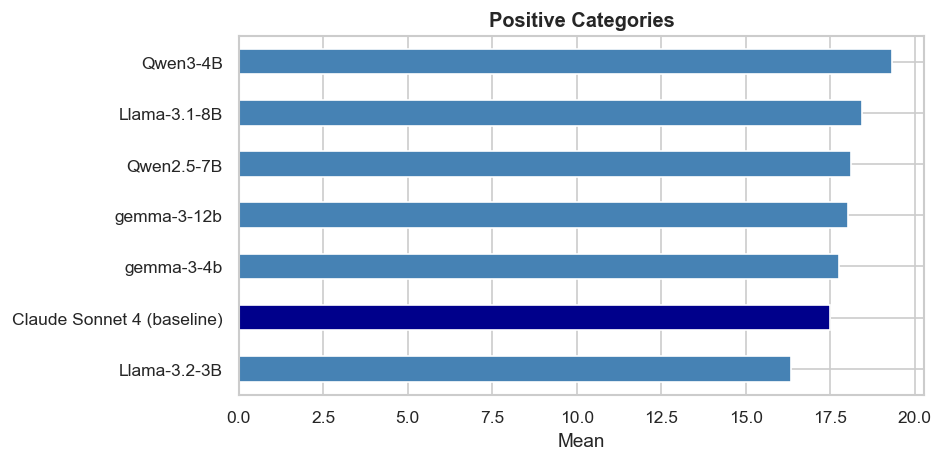

,positive_mean
evaluator_short,
Llama-3.2-3B,16.338973
Claude Sonnet 4 (baseline),17.480694
gemma-3-4b,17.766623
gemma-3-12b,18.031261
Qwen2.5-7B,18.109347
Llama-3.1-8B,18.444158
Qwen3-4B,19.319487


In [11]:
evaluator_pos = all_df.groupby("evaluator_short")[positive_cols].mean()
pos_mean = evaluator_pos.mean(axis=1)

baseline_df = pd.read_csv(baseline_path)
ref_label = "Claude Sonnet 4 (baseline)"
pos_mean.loc[ref_label] = baseline_df[positive_cols].mean().mean()

pos_mean = pos_mean.sort_values(ascending=True)

plt.figure(figsize=(8, 4))
colors = ["steelblue"] * len(pos_mean)
colors[list(pos_mean.index).index(ref_label)] = "darkblue"
pos_mean.plot(kind="barh", color=colors)
plt.title("Positive Categories", fontsize=12, fontweight="bold")
plt.xlabel("Mean")
plt.ylabel("")
plt.tight_layout()
plt.show()

pos_mean.to_frame("positive_mean")


### Negative category means
- Mean scores across 9 **negative/penalty** categories per evaluator
- **Lower** values = evaluator flags fewer issues (Meandering, Weak Dialogue, etc.) → less strict

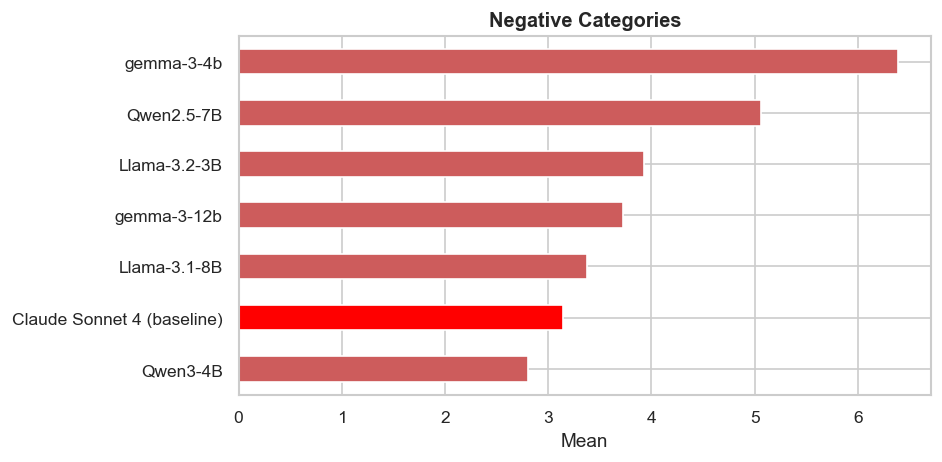

,negative_mean
evaluator_short,
Qwen3-4B,2.808156
Claude Sonnet 4 (baseline),3.142547
Llama-3.1-8B,3.377256
gemma-3-12b,3.723859
Llama-3.2-3B,3.928393
Qwen2.5-7B,5.060988
gemma-3-4b,6.388237


In [12]:
evaluator_neg = all_df.groupby("evaluator_short")[negative_cols].mean()
neg_mean = evaluator_neg.mean(axis=1)

baseline_df = pd.read_csv(baseline_path)
ref_label = "Claude Sonnet 4 (baseline)"
neg_mean.loc[ref_label] = baseline_df[negative_cols].mean().mean()

neg_mean = neg_mean.sort_values(ascending=True)

plt.figure(figsize=(8, 4))
colors = ["indianred"] * len(neg_mean)
colors[list(neg_mean.index).index(ref_label)] = "red"
neg_mean.plot(kind="barh", color=colors)
plt.title("Negative Categories", fontsize=12, fontweight="bold")
plt.xlabel("Mean")
plt.ylabel("")
plt.tight_layout()
plt.show()

neg_mean.to_frame("negative_mean")


## 2. Similarity to Baseline


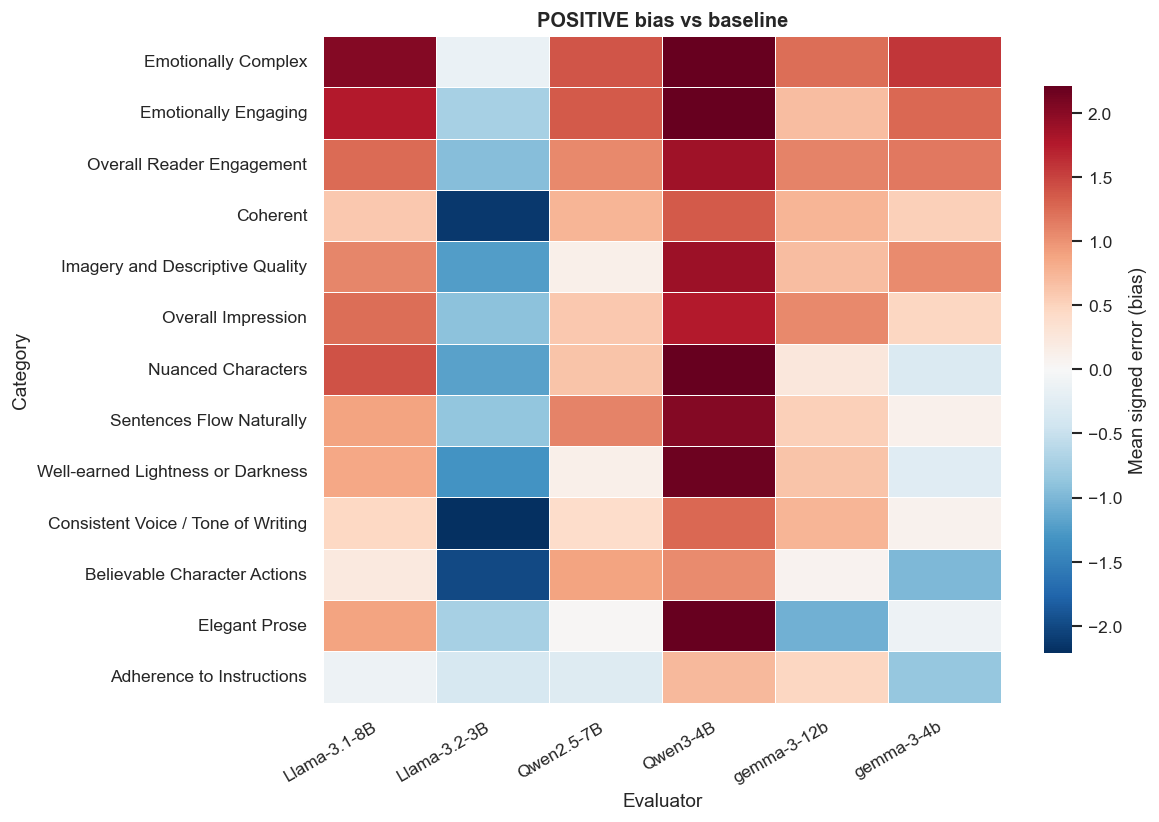

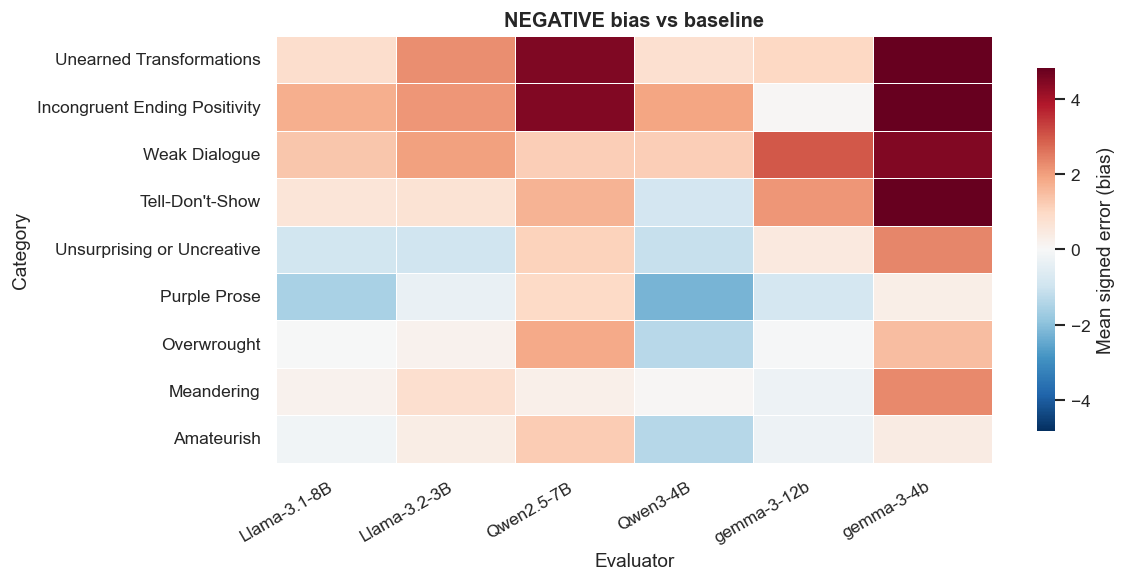

In [13]:
ref = pd.read_csv(baseline_path)
keys = ["index", "model"]

pos_cols = [f"{c}_score" for c in POSITIVE_CATEGORIES]
neg_cols = [f"{c}_score" for c in NEGATIVE_CATEGORIES]

rows = []
for ev, g in all_df.groupby("evaluator_short"):
    m = g.merge(ref, on=keys, suffixes=("_ev", "_ref"), how="inner", validate="one_to_one")
    for c in (pos_cols + neg_cols):
        rows.append({
            "evaluator": ev,
            "category": c.replace("_score", ""),
            "type": "positive" if c in pos_cols else "negative",
            "bias": (m[f"{c}_ev"] - m[f"{c}_ref"]).mean(),
        })

bias_df = pd.DataFrame(rows)

for cat_type, title in [
    ("positive", "POSITIVE bias vs baseline"),
    ("negative", "NEGATIVE bias vs baseline"),
]:
    sub = bias_df[bias_df["type"] == cat_type]
    pivot = sub.pivot_table(index="category", columns="evaluator", values="bias")

    pivot["avg_abs"] = pivot.abs().mean(axis=1)
    pivot = pivot.sort_values("avg_abs", ascending=False).drop(columns=["avg_abs"])
    pivot = pivot[sorted(pivot.columns)]

    vals = pivot.to_numpy().ravel()
    v = float(np.nanpercentile(np.abs(vals), 95))
    if not np.isfinite(v) or v == 0:
        v = float(np.nanmax(np.abs(vals)))

    plt.figure(figsize=(10, 5 if cat_type == "negative" else 7))
    ax = sns.heatmap(
        pivot,
        cmap="RdBu_r",
        center=0.0,
        vmin=-v,
        vmax=v,
        annot=False,
        linewidths=0.4,
        linecolor="white",
        cbar_kws={"label": "Mean signed error (bias)", "shrink": 0.85},
    )
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Evaluator")
    ax.set_ylabel("Category")
    plt.xticks(rotation=30, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


## 3. Error metrics vs baseline (MAE / RMSE)


### Bias vs baseline
- Heatmap of mean score differences for the **same stories** between each evaluator and baseline (Claude)
- **Positive bias**: evaluator gives higher scores than baseline
- **Negative bias**: evaluator assigns higher penalty scores (flags more issues) than baseline

,evaluator,pos_mae,pos_rmse,neg_mae,neg_rmse,overall_mae,overall_rmse
4,gemma-3-12b,1.005827,1.325705,1.482370,2.044958,1.200776,1.658095
3,Qwen3-4B,1.854438,2.174489,1.500087,1.878685,1.709476,2.058622
2,Qwen2.5-7B,1.110350,1.466203,2.269738,2.970508,1.584645,2.209093
0,Llama-3.1-8B,1.350326,1.831399,2.214718,3.362956,1.703941,2.570705
5,gemma-3-4b,1.058670,1.400138,3.500942,4.479265,2.057781,3.060447
1,Llama-3.2-3B,3.201153,6.163627,3.408388,5.148472,3.285931,5.769964


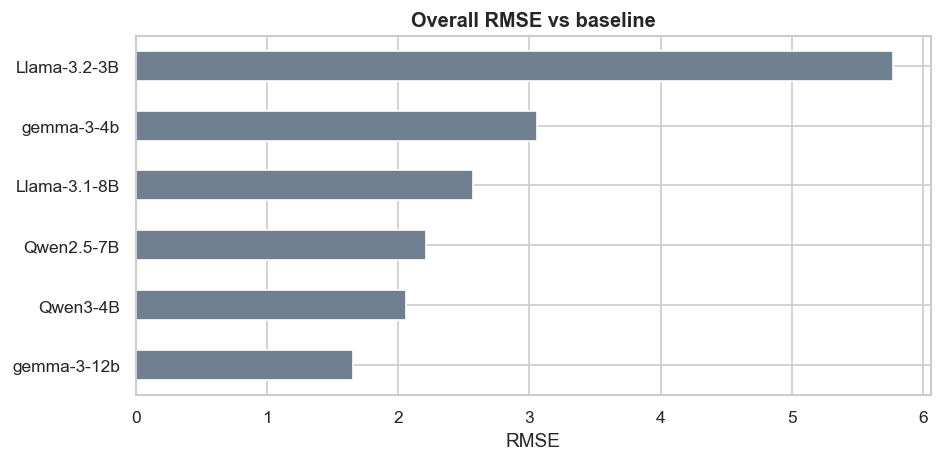

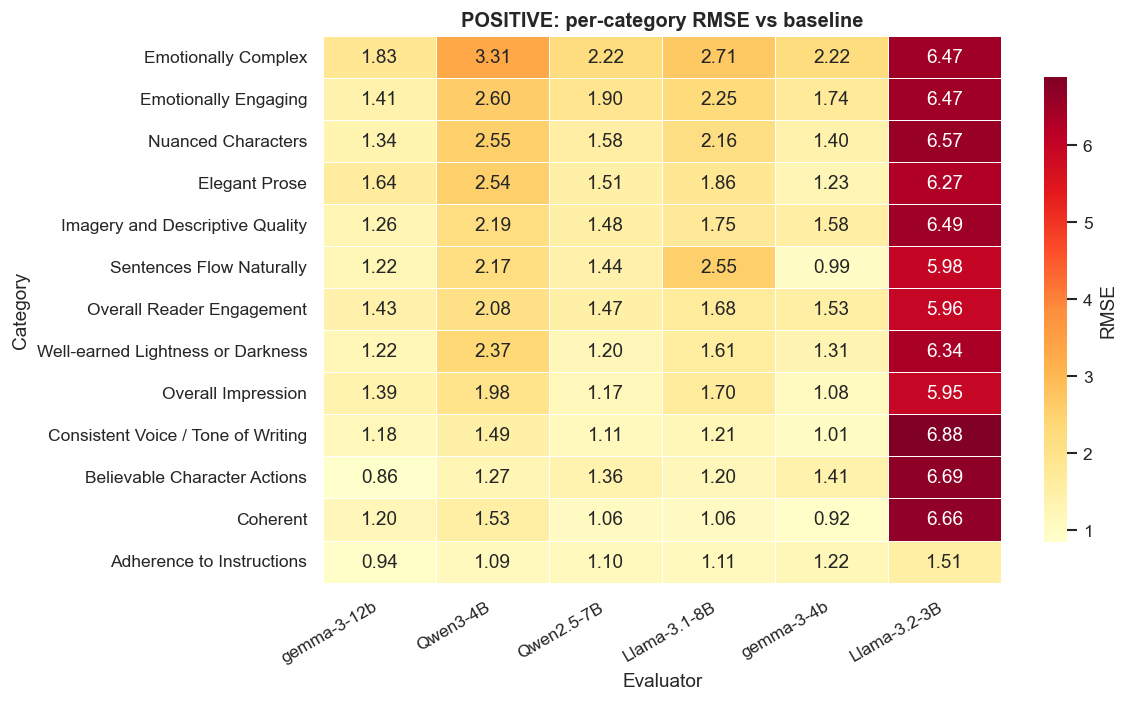

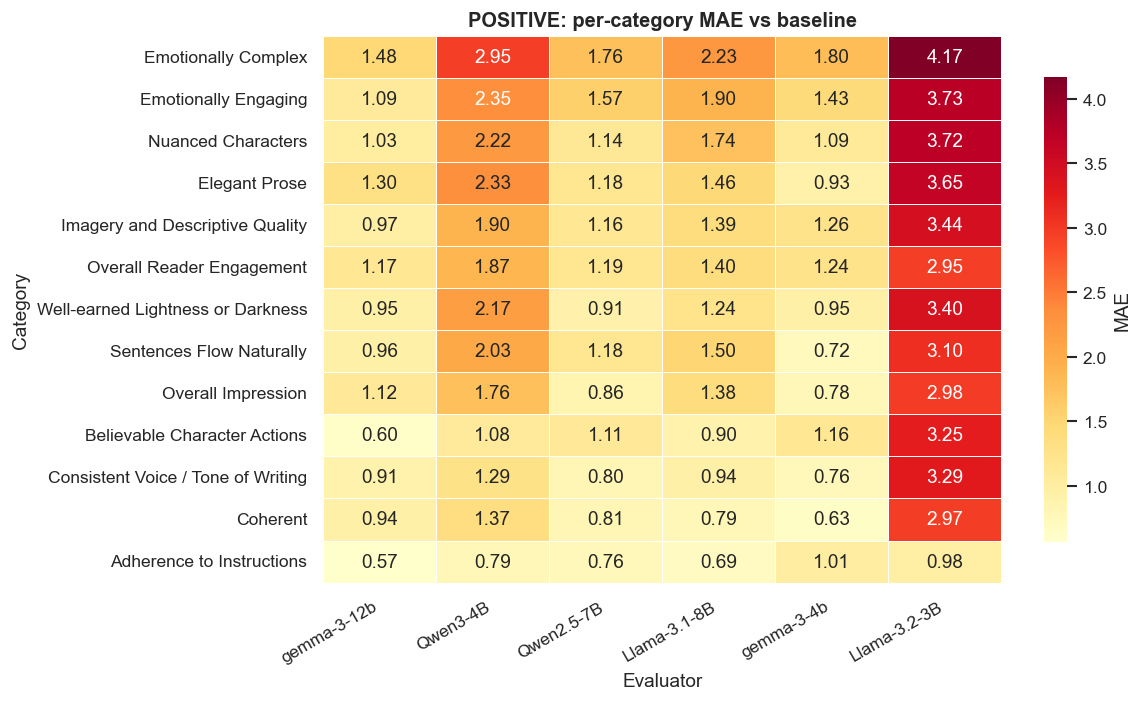

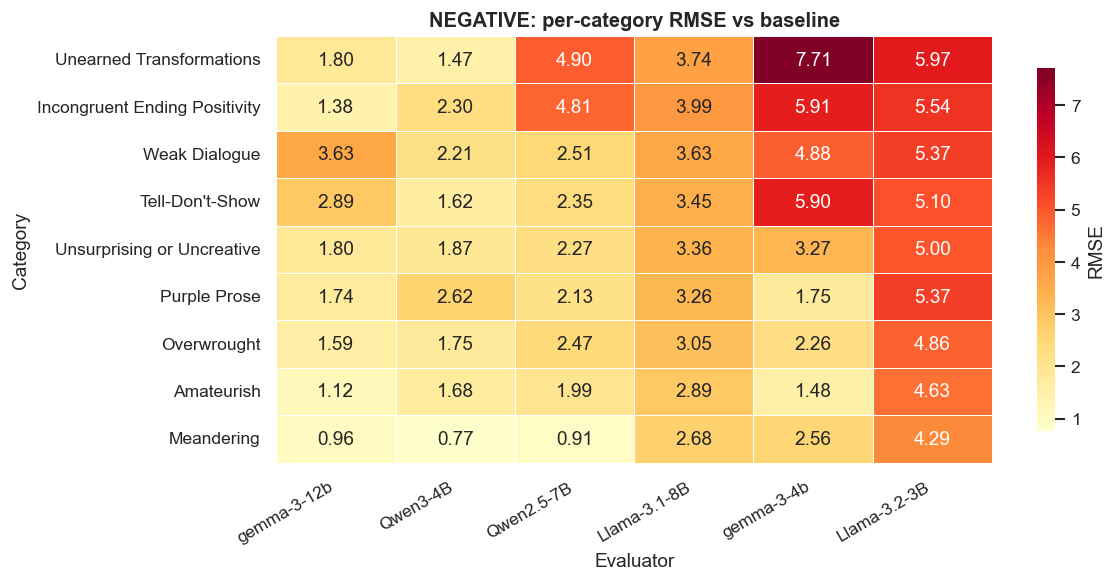

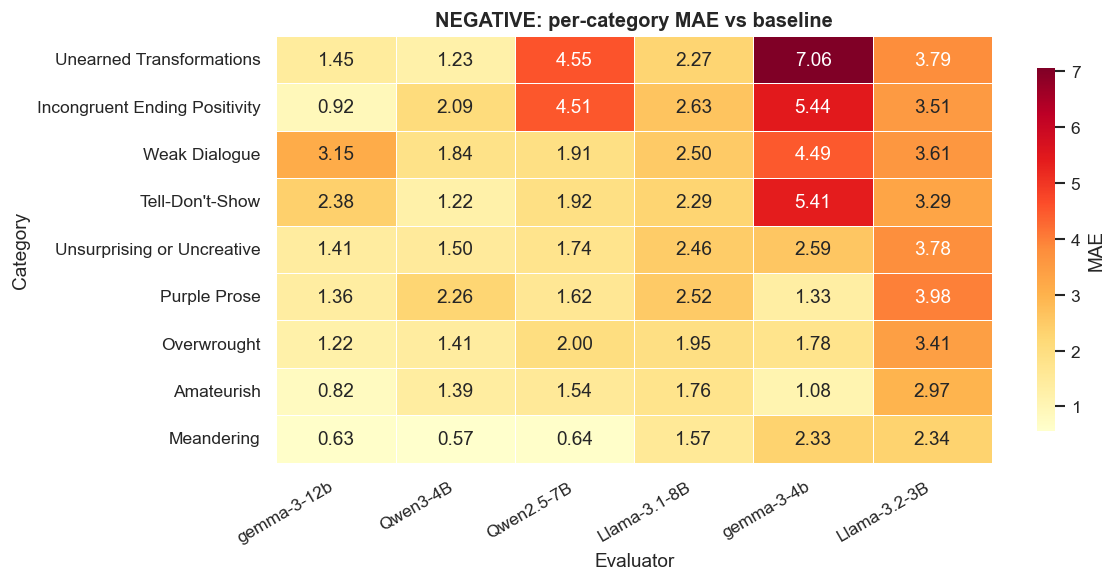

In [14]:
from IPython.display import display

ref = pd.read_csv(baseline_path)
keys = ["index", "model"]

pos_cols = [f"{c}_score" for c in POSITIVE_CATEGORIES]
neg_cols = [f"{c}_score" for c in NEGATIVE_CATEGORIES]
all_cols = pos_cols + neg_cols

summary_rows = []
per_cat_rows = []

for ev, g in all_df.groupby("evaluator_short"):
    m = g.merge(ref, on=keys, suffixes=("_ev", "_ref"), how="inner", validate="one_to_one")

    def mae_mse_rmse(cols: list[str]) -> tuple[float, float, float]:
        diffs = [(m[f"{c}_ev"] - m[f"{c}_ref"]).to_numpy() for c in cols]
        diffs = np.concatenate(diffs)
        mae = float(np.mean(np.abs(diffs)))
        mse = float(np.mean(diffs ** 2))
        rmse = float(np.sqrt(mse))
        return mae, mse, rmse

    pos_mae, _, pos_rmse = mae_mse_rmse(pos_cols)
    neg_mae, _, neg_rmse = mae_mse_rmse(neg_cols)
    all_mae, _, all_rmse = mae_mse_rmse(all_cols)

    summary_rows.append({
        "evaluator": ev,
        "pos_mae": pos_mae,
        "pos_rmse": pos_rmse,
        "neg_mae": neg_mae,
        "neg_rmse": neg_rmse,
        "overall_mae": all_mae,
        "overall_rmse": all_rmse,
    })

    for c in all_cols:
        diff = (m[f"{c}_ev"] - m[f"{c}_ref"]).to_numpy()
        mae = float(np.mean(np.abs(diff)))
        mse = float(np.mean(diff ** 2))
        per_cat_rows.append({
            "evaluator": ev,
            "category": c.replace("_score", ""),
            "type": "positive" if c in pos_cols else "negative",
            "mae": mae,
            "rmse": float(np.sqrt(mse)),
        })

metrics_summary = pd.DataFrame(summary_rows).sort_values("overall_rmse", ascending=True)
display(metrics_summary)

plt.figure(figsize=(8, 4))
metrics_summary.set_index("evaluator")["overall_rmse"].plot(kind="barh", color="slategray")
plt.title("Overall RMSE vs baseline", fontsize=12, fontweight="bold")
plt.xlabel("RMSE")
plt.ylabel("")
plt.tight_layout()
plt.show()

per_cat = pd.DataFrame(per_cat_rows)

for cat_type, title_prefix in [
    ("positive", "POSITIVE"),
    ("negative", "NEGATIVE"),
]:
    sub = per_cat[per_cat["type"] == cat_type]

    rmse_pivot = sub.pivot_table(index="category", columns="evaluator", values="rmse")
    rmse_pivot["avg"] = rmse_pivot.mean(axis=1)
    rmse_pivot = rmse_pivot.sort_values("avg", ascending=False).drop(columns=["avg"])
    rmse_pivot = rmse_pivot[metrics_summary["evaluator"].tolist()]

    plt.figure(figsize=(10, 6 if cat_type == "positive" else 5))
    ax = sns.heatmap(
        rmse_pivot,
        cmap="YlOrRd",
        annot=True,
        fmt=".2f",
        linewidths=0.4,
        linecolor="white",
        cbar_kws={"label": "RMSE", "shrink": 0.85},
    )
    ax.set_title(f"{title_prefix}: per-category RMSE vs baseline", fontsize=12, fontweight="bold")
    ax.set_xlabel("Evaluator")
    ax.set_ylabel("Category")
    plt.xticks(rotation=30, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    mae_pivot = sub.pivot_table(index="category", columns="evaluator", values="mae")
    mae_pivot["avg"] = mae_pivot.mean(axis=1)
    mae_pivot = mae_pivot.sort_values("avg", ascending=False).drop(columns=["avg"])
    mae_pivot = mae_pivot[metrics_summary["evaluator"].tolist()]

    plt.figure(figsize=(10, 6 if cat_type == "positive" else 5))
    ax = sns.heatmap(
        mae_pivot,
        cmap="YlOrRd",
        annot=True,
        fmt=".2f",
        linewidths=0.4,
        linecolor="white",
        cbar_kws={"label": "MAE", "shrink": 0.85},
    )
    ax.set_title(f"{title_prefix}: per-category MAE vs baseline", fontsize=12, fontweight="bold")
    ax.set_xlabel("Evaluator")
    ax.set_ylabel("Category")
    plt.xticks(rotation=30, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


### Error metrics (MAE / RMSE)
- **MAE (Mean Absolute Error)**: average absolute difference from baseline — lower = closer to baseline
- **RMSE (Root Mean Squared Error)**: penalizes larger errors — useful for detecting extreme disagreements
- Bar chart: overall RMSE ranking across evaluators
- Heatmap: per-category error distribution

---

## Results & conclusions

### Model results

| Evaluator | Positive mean ↑ | Negative mean ↓ | Overall RMSE vs baseline ↓ |
|-----------|-----------------|-----------------|----------------------------|
| Qwen3-4B | 19.32 | 2.81 | 2.06 |
| Llama-3.1-8B | 18.44 | 3.38 | 2.57 |
| Qwen2.5-7B | 18.11 | 5.06 | 2.21 |
| gemma-3-12b | 18.03 | 3.72 | **1.66** |
| gemma-3-4b | 17.77 | 6.39 | 3.06 |
| Claude Sonnet 4 (baseline) | 17.48 | 3.14 | — |
| Llama-3.2-3B | 16.34 | 3.93 | 5.77 |

### Closest to Claude Sonnet 4

- **gemma-3-12b** has the lowest overall RMSE (1.66) and is the closest to the baseline.
- Next closest: **Qwen3-4B** (2.06), **Qwen2.5-7B** (2.21), **Llama-3.1-8B** (2.57).
- **Llama-3.2-3B** has the highest RMSE (5.77) and is farthest from Claude.

### Trends

1. **Larger models tend to align better with Claude**: gemma-3-12b (12B) > gemma-3-4b (4B); Llama-3.1-8B (8B) > Llama-3.2-3B (3B).
2. **Newer or smaller does not imply more similar**: Llama-3.2-3B (newer, smaller) is the least similar.
3. **Within families**: Among Qwen models, Qwen2.5-7B has slightly lower RMSE than Qwen3-4B, despite Qwen3-4B being newer and giving higher positive / lower negative means.
4. **Score inflation**: Qwen3-4B tends to score highest on positive categories (19.32) and lowest on negative (2.81); Llama-3.2-3B is the most conservative (16.34 positive mean).